# 2段階のNLモデルの構築
上位：私事トリップ選択モデル（しないor義務or裁量）  
下位：端末選択モデル
### 5との違い
- ネストパラメータの導入方法が異なる

In [1]:
# ライブラリの導入
# ライブラリの導入
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Noto Sans CJK JP"  # 日本語入力対応
import time

import biogeme.biogeme_logging as blog

from biogeme.database import Database
from biogeme.expressions import Variable, Beta
from biogeme.biogeme import BIOGEME
from biogeme.models import lognested
from biogeme.models import nested
from biogeme.nests import OneNestForNestedLogit, NestsForNestedLogit
from biogeme.results_processing import get_pandas_estimated_parameters

/home/shibumtk/B4research/estimate/.venv/lib/python3.12/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# 入力データの読み込み
master_df = pd.read_csv("/home/shibumtk/B4research/estimate/data/NL_data/c_NL_Logit_master2.csv", encoding="utf-8-sig")
master_df = master_df.fillna(0) # 欠損値を一応埋める

# 文字列は除外する
drop_cols =['NearestStation', 'WorkplaceStation']
master_df = master_df.drop(columns=drop_cols)

# 確認
print(len(master_df))
master_df.columns

46738


Index(['Personal_ID', 'HouseholdIncome', 'sex', 'age', 'JobType',
       'ComuTime[m]', 'MainlineTime[m]', 'AccessTime_used[m]', 'HouseholdType',
       'HouseholdMembers(all)', 'YoungestMember_No', 'WorkTime[m]',
       'AfterTime_work[m]', 'AfterTime_home[m]', 'first_transportation',
       'NearestStation_code', 'near_chuko_area300', 'near_chuko_area1000',
       'near_300index1', 'near_1000index1', 'near_300index2',
       'near_1000index2', 'WorkplaceStation_code', 'WP_chuko_area300',
       'WP_chuko_area1000', 'WP_300index1', 'WP_1000index1', 'WP_300index2',
       'WP_1000index2', 'PriTrip', 'timing', 'FacilityType', 'TripPurpose',
       'PriTrip_class', 'StayTime', 'walk_av', 'walk_time[m]', 'bicycle_av',
       'bicycle_time[m]', 'bicycle_parking_fee', 'bus_av', 'bus_time[m]',
       'bus_cost', 'dist_nearest_BusStop[km]', 'car_av', 'car_time[m]',
       'car_cost'],
      dtype='object')

In [3]:
# NL用のCHOICEカラムを作成
mode_map = {1:0, 2:1, 4:2, 5:3} # 端末手段を0~3にまとめる
# 端末手段のカラムを書き換え（新しいカラムを作成）
master_df["t_first_transportation"] = master_df["first_transportation"].map(mode_map)

df = master_df.copy()
# CHOICEカラム
df['CHOICE9'] = np.select(
    [df['PriTrip_class'] == 0, df['PriTrip_class'] == 1, df['PriTrip_class'] == 2],
    [1, 2 + df['t_first_transportation'], 6 + df['t_first_transportation']]
).astype("int64")

t_master_df = df.copy()

# 確認
print(t_master_df['CHOICE9'].value_counts().sort_index().sum())
t_master_df['CHOICE9'].value_counts().sort_index()

46738


CHOICE9
1    38142
2     2954
3      438
4      299
5       64
6     3912
7      420
8      417
9       92
Name: count, dtype: int64

In [4]:
# 性別ごとのデータだけ抽出
male_df   = t_master_df[t_master_df['sex'] == 1].copy()
female_df = t_master_df[t_master_df['sex'] == 2].copy()

# 確認
print("男性データ数", len(male_df))
print("女性データ数", len(female_df))

男性データ数 30350
女性データ数 16388


In [5]:
# biogemeデータリストに格納する
master_db = Database("male_PTdata", male_df)

In [6]:
# ==============
# 変数定義
# ==============
CHOICE = Variable("CHOICE9")

# availability & time
WA_AV = Variable("walk_av")
WA_TT = Variable("walk_time[m]")

BI_AV = Variable("bicycle_av")
BI_TT = Variable("bicycle_time[m]")

BU_AV = Variable("bus_av")
BU_TT = Variable("bus_time[m]")

CA_AV = Variable("car_av")
CA_TT = Variable("car_time[m]")

# Trip-level covariates
WORKTIME    = Variable("WorkTime[m]")
AF_WORKTIME = Variable("AfterTime_work[m]") # AF=after
MACMTIME    = Variable("MainlineTime[m]")
HHM_all     = Variable("HouseholdMembers(all)")
NEKI_INDEX  = Variable("near_1000index2")
WEKI_INDEX  = Variable("WP_1000index2") # 就業地駅土地利用指標

# scaled
WORKTIME_SCALED    = master_db.define_variable("WORKTIME_SCALED", WORKTIME / 60)
AF_WORKTIME_SCALED = master_db.define_variable("AF_WORKTIME_SCALED", AF_WORKTIME / 60)
MACMTIME_SCALED    = master_db.define_variable("MACMTIME_SCALED", MACMTIME / 60)
NEKI_SCALED        = master_db.define_variable("NEKI_SCALED", NEKI_INDEX / 1_000_000)
WEKI_SCALED        = master_db.define_variable("WEKI_SCALED", WEKI_INDEX / 1_000_000)

# ==============
# パラメータ
# ==============
# モード側ASC（walk基準）
ASC_BI = Beta("ASC_BI", 0, None, None, 0)
ASC_BU = Beta("ASC_BU", 0, None, None, 0)
ASC_CA = Beta("ASC_CA", 0, None, None, 0)

# 端末時間係数（共通変数）
b_at = Beta("b_at", 0, None, None, 0)

# Trip-type（Duty/Disc）側
ASC_DU = Beta("ASC_DU", 0, None, None, 0)
ASC_DI = Beta("ASC_DI", 0, None, None, 0)

# 独立に導入する説明変数
b_work_du        = Beta("b_work_du", 0, None, None, 0)
b_macmtime_du    = Beta("b_macmtime_du", 0, None, None, 0)
b_n_eki_du       = Beta("b_n_eki_du", 0, None, None, 0)
b_w_eki_du       = Beta("b_w_eki_du", 0, None, None, 0)
b_hhm_du         = Beta("b_hhm_du", 0, None, None, 0)

b_work_di        = Beta("b_work_di", 0, None, None, 0)
b_macmtime_di    = Beta("b_macmtime_di", 0, None, None, 0)
b_n_eki_di       = Beta("b_n_eki_di", 0, None, None, 0)
b_w_eki_di       = Beta("b_w_eki_di", 0, None, None, 0)
b_hhm_di         = Beta("b_hhm_di", 0, None, None, 0)

# 共通変数
b_aftime_work = Beta("b_aftime_work", 0, None, None, 0)

# ネストパラメータ（NoTripは単一代替なので固定=1）
# NoTripは単一代替なら μ を置いても効かないので固定でOK
MU_NO = Beta("MU_NO", 1.0, 1.0, 1.0, 1)

# λを推定
LAMBDA_DU = Beta("LAMBDA_DU", 0.8, 0.01, 1.0, 0)  # (0,1]に制約
LAMBDA_DI = Beta("LAMBDA_DI", 0.8, 0.01, 1.0, 0)  # (0,1]に制約
MU_DU = 1 / LAMBDA_DU
MU_DI = 1 / LAMBDA_DI

# ==============
# 代替ID（9択）
# ==============
NO      = 1
DU_WA   = 2
DU_BI   = 3
DU_BU   = 4
DU_CA   = 5
DI_WA   = 6
DI_BI   = 7
DI_BU   = 8
DI_CA   = 9

# ==============
# 効用
# NoTripは基準：0
# ==============
V_NO = 0

# Trip-type utility（Duty/Disc）
V_DU_PRI = (ASC_DU
            + b_aftime_work * AF_WORKTIME_SCALED
            + b_macmtime_du * MACMTIME_SCALED
            + b_n_eki_du    * NEKI_SCALED
            + b_hhm_du      * HHM_all)

V_DI_PRI = (ASC_DI
            + b_aftime_work * AF_WORKTIME_SCALED
            + b_macmtime_di * MACMTIME_SCALED
            + b_n_eki_di    * NEKI_SCALED
            + b_hhm_di      * HHM_all)

# Mode utility（walk基準でASC=0）
V_WA_MODE = b_at * WA_TT
V_BI_MODE = ASC_BI + b_at * BI_TT
V_BU_MODE = ASC_BU + b_at * BU_TT
V_CA_MODE = ASC_CA + b_at * CA_TT

# 9 alternatives utilities
V = {
    NO:    V_NO,

    DU_WA: V_DU_PRI + V_WA_MODE,
    DU_BI: V_DU_PRI + V_BI_MODE,
    DU_BU: V_DU_PRI + V_BU_MODE,
    DU_CA: V_DU_PRI + V_CA_MODE,

    DI_WA: V_DI_PRI + V_WA_MODE,
    DI_BI: V_DI_PRI + V_BI_MODE,
    DI_BU: V_DI_PRI + V_BU_MODE,
    DI_CA: V_DI_PRI + V_CA_MODE
}

# availability（NoTripは常に利用可能=1）
av = {
    NO: 1,

    DU_WA: WA_AV,
    DU_BI: BI_AV,
    DU_BU: BU_AV,
    DU_CA: CA_AV,

    DI_WA: WA_AV,
    DI_BI: BI_AV,
    DI_BU: BU_AV,
    DI_CA: CA_AV,
}

# ==============
# nests（上位＝{NoTrip, Duty, Discretion}）
# ==============
nest_no = OneNestForNestedLogit(MU_NO, [NO], name="NoTrip")
nest_du = OneNestForNestedLogit(MU_DU, [DU_WA, DU_BI, DU_BU, DU_CA], name="Duty")
nest_di = OneNestForNestedLogit(MU_DI, [DI_WA, DI_BI, DI_BU, DI_CA], name="Discretion")

nests = NestsForNestedLogit(
    choice_set=list(V.keys()),
    tuple_of_nests=(nest_no, nest_du, nest_di)
)

In [7]:
# loglikelihood
logprob = lognested(V, av, nests, CHOICE)

# estimate
logger = blog.get_screen_logger(level=blog.INFO)
biogeme = BIOGEME(
    master_db,
    logprob,
    generate_html=False,
    generate_yaml=False,
    optimization_algorithm="simple_bounds_BFGS",
    calculating_second_derivatives="never", 
    save_iterations=False
)
biogeme.model_name = "NL_NoTrip0_DutyDisc_Mode2_male"

biogeme.calculate_null_loglikelihood(av)
male_results = biogeme.estimate()
print("estimate() returned") 
print(male_results.short_summary())

# パラメータ推定値をpandasに格納して表示
pandas_male_results = get_pandas_estimated_parameters(estimation_results=male_results)
print(pandas_male_results.to_string)

Biogeme parameters read from biogeme.toml. 


Starting values for the algorithm: {} 
Optimization algorithm: BFGS with simple bounds [simple_bounds_BFGS]. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: BFGS with trust region for simple bounds 
E0120 21:48:15.278318   44949 slow_operation_alarm.cc:73] 
********************************
[Compiling module jit_sum_function for CPU] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
E0120 21:49:16.628346   43537 slow_operation_alarm.cc:140] The operation took 3m1.351359057s

********************************
[Compiling module jit_sum_function for CPU] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Iter.          ASC_DU   b_aftime_work   b_macmtime_du      b_n_eki_du        b_hhm_du            b_at       LAMBDA_DU          ASC_BI        

estimate() returned
Results for model NL_NoTrip0_DutyDisc_Mode2_male
Nbr of parameters:		15
Sample size:			30350
Excluded data:			0
Null log likelihood:		-55558.39
Final log likelihood:		-15136.46
Likelihood ratio test (null):		80843.85
Rho square (null):			0.728
Rho bar square (null):			0.727
Akaike Information Criterion:	30302.92
Bayesian Information Criterion:	30427.73

<bound method DataFrame.to_string of              Name     Value  BHHH std err.  BHHH t-stat.  BHHH p-value
0          ASC_DU -6.168966       0.147826    -41.731146  0.000000e+00
1   b_aftime_work  0.518701       0.012587     41.210133  0.000000e+00
2   b_macmtime_du -0.546193       0.077660     -7.033136  2.019496e-12
3      b_n_eki_du  0.213515       0.071185      2.999420  2.704940e-03
4        b_hhm_du -0.262115       0.022481    -11.659187  0.000000e+00
5            b_at -0.017158       0.002611     -6.570266  5.022560e-11
6       LAMBDA_DU  0.055756       0.009391      5.936924  2.904190e-09
7          ASC_BI -

In [8]:
pandas_male_results.to_csv("/home/shibumtk/B4research/estimate/data/results/NL_2nest_estimated_parameters6_male.csv", index=False, encoding="utf-8-sig")
print("saved: estimated_parameters6_male.csv")

saved: estimated_parameters6_male.csv


In [9]:
# biogemeデータリストに格納する
master_db = Database("female_PTdata", female_df)

In [10]:
# ==============
# 変数定義
# ==============
CHOICE = Variable("CHOICE9")

# availability & time
WA_AV = Variable("walk_av")
WA_TT = Variable("walk_time[m]")

BI_AV = Variable("bicycle_av")
BI_TT = Variable("bicycle_time[m]")

BU_AV = Variable("bus_av")
BU_TT = Variable("bus_time[m]")

CA_AV = Variable("car_av")
CA_TT = Variable("car_time[m]")

# Trip-level covariates
WORKTIME    = Variable("WorkTime[m]")
AF_WORKTIME = Variable("AfterTime_work[m]") # AF=after
MACMTIME    = Variable("MainlineTime[m]")
HHM_all     = Variable("HouseholdMembers(all)")
NEKI_INDEX  = Variable("near_1000index2")
WEKI_INDEX  = Variable("WP_1000index2") # 就業地駅土地利用指標

# scaled
WORKTIME_SCALED    = master_db.define_variable("WORKTIME_SCALED", WORKTIME / 60)
AF_WORKTIME_SCALED = master_db.define_variable("AF_WORKTIME_SCALED", AF_WORKTIME / 60)
MACMTIME_SCALED    = master_db.define_variable("MACMTIME_SCALED", MACMTIME / 60)
NEKI_SCALED        = master_db.define_variable("NEKI_SCALED", NEKI_INDEX / 1_000_000)
WEKI_SCALED        = master_db.define_variable("WEKI_SCALED", WEKI_INDEX / 1_000_000)

# ==============
# パラメータ
# ==============
# モード側ASC（walk基準）
ASC_BI = Beta("ASC_BI", 0, None, None, 0)
ASC_BU = Beta("ASC_BU", 0, None, None, 0)
ASC_CA = Beta("ASC_CA", 0, None, None, 0)

# 端末時間係数（共通変数）
b_at = Beta("b_at", 0, None, None, 0)

# Trip-type（Duty/Disc）側
ASC_DU = Beta("ASC_DU", 0, None, None, 0)
ASC_DI = Beta("ASC_DI", 0, None, None, 0)

# 独立に導入する説明変数
b_work_du        = Beta("b_work_du", 0, None, None, 0)
b_macmtime_du    = Beta("b_macmtime_du", 0, None, None, 0)
b_n_eki_du       = Beta("b_n_eki_du", 0, None, None, 0)
b_w_eki_du       = Beta("b_w_eki_du", 0, None, None, 0)
b_hhm_du         = Beta("b_hhm_du", 0, None, None, 0)

b_work_di        = Beta("b_work_di", 0, None, None, 0)
b_macmtime_di    = Beta("b_macmtime_di", 0, None, None, 0)
b_n_eki_di       = Beta("b_n_eki_di", 0, None, None, 0)
b_w_eki_di       = Beta("b_w_eki_di", 0, None, None, 0)
b_hhm_di         = Beta("b_hhm_di", 0, None, None, 0)

# 共通変数
b_aftime_work = Beta("b_aftime_work", 0, None, None, 0)

# ネストパラメータ（NoTripは単一代替なので固定=1）
# NoTripは単一代替なら μ を置いても効かないので固定でOK
MU_NO = Beta("MU_NO", 1.0, 1.0, 1.0, 1)

# λを推定
LAMBDA_DU = Beta("LAMBDA_DU", 0.8, 0.01, 1.0, 0)  # (0,1]に制約
LAMBDA_DI = Beta("LAMBDA_DI", 0.8, 0.01, 1.0, 0)  # (0,1]に制約
MU_DU = 1 / LAMBDA_DU
MU_DI = 1 / LAMBDA_DI

# ==============
# 代替ID（9択）
# ==============
NO      = 1
DU_WA   = 2
DU_BI   = 3
DU_BU   = 4
DU_CA   = 5
DI_WA   = 6
DI_BI   = 7
DI_BU   = 8
DI_CA   = 9

# ==============
# 効用
# NoTripは基準：0
# ==============
V_NO = 0

# Trip-type utility（Duty/Disc）
V_DU_PRI = (ASC_DU
            + b_aftime_work * AF_WORKTIME_SCALED
            + b_macmtime_du * MACMTIME_SCALED
            + b_n_eki_du    * NEKI_SCALED
            + b_hhm_du      * HHM_all)

V_DI_PRI = (ASC_DI
            + b_aftime_work * AF_WORKTIME_SCALED
            + b_macmtime_di * MACMTIME_SCALED
            + b_n_eki_di    * NEKI_SCALED
            + b_hhm_di      * HHM_all)

# Mode utility（walk基準でASC=0）
V_WA_MODE = b_at * WA_TT
V_BI_MODE = ASC_BI + b_at * BI_TT
V_BU_MODE = ASC_BU + b_at * BU_TT
V_CA_MODE = ASC_CA + b_at * CA_TT

# 9 alternatives utilities
V = {
    NO:    V_NO,

    DU_WA: V_DU_PRI + V_WA_MODE,
    DU_BI: V_DU_PRI + V_BI_MODE,
    DU_BU: V_DU_PRI + V_BU_MODE,
    DU_CA: V_DU_PRI + V_CA_MODE,

    DI_WA: V_DI_PRI + V_WA_MODE,
    DI_BI: V_DI_PRI + V_BI_MODE,
    DI_BU: V_DI_PRI + V_BU_MODE,
    DI_CA: V_DI_PRI + V_CA_MODE
}

# availability（NoTripは常に利用可能=1）
av = {
    NO: 1,

    DU_WA: WA_AV,
    DU_BI: BI_AV,
    DU_BU: BU_AV,
    DU_CA: CA_AV,

    DI_WA: WA_AV,
    DI_BI: BI_AV,
    DI_BU: BU_AV,
    DI_CA: CA_AV,
}

# ==============
# nests（上位＝{NoTrip, Duty, Discretion}）
# ==============
nest_no = OneNestForNestedLogit(MU_NO, [NO], name="NoTrip")
nest_du = OneNestForNestedLogit(MU_DU, [DU_WA, DU_BI, DU_BU, DU_CA], name="Duty")
nest_di = OneNestForNestedLogit(MU_DI, [DI_WA, DI_BI, DI_BU, DI_CA], name="Discretion")

nests = NestsForNestedLogit(
    choice_set=list(V.keys()),
    tuple_of_nests=(nest_no, nest_du, nest_di)
)

In [11]:
# loglikelihood
logprob = lognested(V, av, nests, CHOICE)

# estimate
logger = blog.get_screen_logger(level=blog.INFO)
biogeme = BIOGEME(
    master_db,
    logprob,
    generate_html=False,
    generate_yaml=False,
    optimization_algorithm="simple_bounds_BFGS",
    calculating_second_derivatives="never", 
    save_iterations=False
)
biogeme.model_name = "NL_NoTrip0_DutyDisc_Mode2_female"

biogeme.calculate_null_loglikelihood(av)
female_results = biogeme.estimate()
print("estimate() returned") 
print(female_results.short_summary())

# パラメータ推定値をpandasに格納して表示
pandas_female_results = get_pandas_estimated_parameters(estimation_results=female_results)
print(pandas_female_results.to_string)

Biogeme parameters read from biogeme.toml. 
Biogeme parameters read from biogeme.toml. 
Starting values for the algorithm: {} 
Starting values for the algorithm: {} 
Optimization algorithm: BFGS with simple bounds [simple_bounds_BFGS]. 
Optimization algorithm: BFGS with simple bounds [simple_bounds_BFGS]. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: BFGS with trust region for simple bounds 
** Optimization: BFGS with trust region for simple bounds 
Iter.          ASC_DU   b_aftime_work   b_macmtime_du      b_n_eki_du        b_hhm_du            b_at       LAMBDA_DU          ASC_BI          ASC_BU          ASC_CA          ASC_DI   b_macmtime_di      b_n_eki_di        b_hhm_di       LAMBDA_DI     Function    Relgrad   Radius      Rho      
Iter.          ASC_DU   b_aftime_work   b_macmtime_du      b_n_eki_du        b_hhm_du            b_at       LAMBDA_DU     

estimate() returned
Results for model NL_NoTrip0_DutyDisc_Mode2_female
Nbr of parameters:		15
Sample size:			16388
Excluded data:			0
Null log likelihood:		-27309.76
Final log likelihood:		-13084.64
Likelihood ratio test (null):		28450.25
Rho square (null):			0.521
Rho bar square (null):			0.52
Akaike Information Criterion:	26199.27
Bayesian Information Criterion:	26314.84

<bound method DataFrame.to_string of              Name     Value  BHHH std err.  BHHH t-stat.  BHHH p-value
0          ASC_DU -5.751532       0.158839    -36.209755  0.000000e+00
1   b_aftime_work  0.542939       0.015883     34.183218  0.000000e+00
2   b_macmtime_du -0.480923       0.071992     -6.680239  2.385514e-11
3      b_n_eki_du  0.142649       0.057550      2.478682  1.318689e-02
4        b_hhm_du -0.051130       0.020724     -2.467222  1.361660e-02
5            b_at -0.025982       0.003130     -8.301181  0.000000e+00
6       LAMBDA_DU  0.065734       0.008695      7.560246  4.019007e-14
7          ASC_BI 

In [12]:
pandas_female_results.to_csv("/home/shibumtk/B4research/estimate/data/results/NL_2nest_estimated_parameters6_female.csv", index=False, encoding="utf-8-sig")
print("saved: estimated_parameters6_female.csv")

saved: estimated_parameters6_female.csv


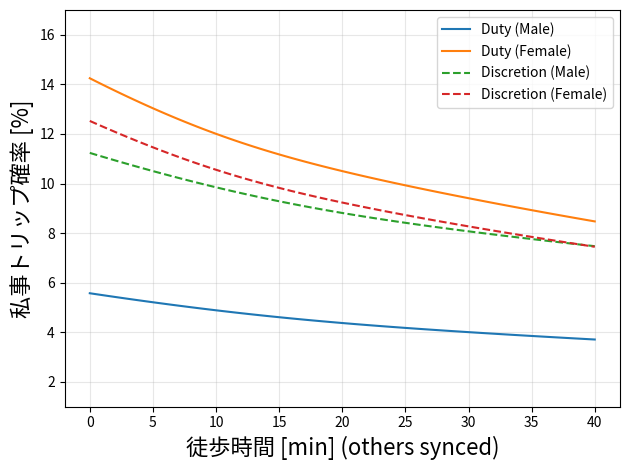

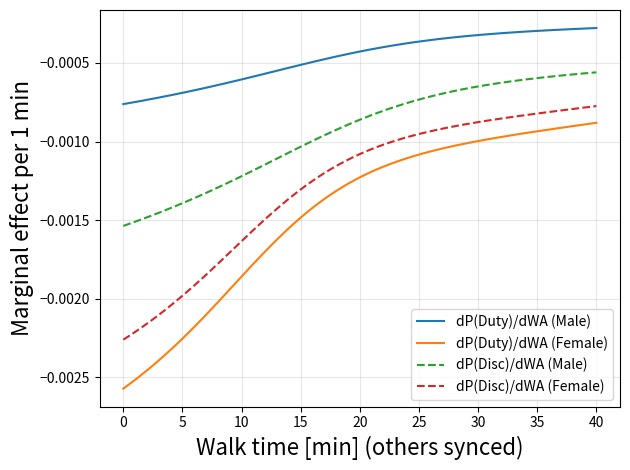

In [13]:
# =========================================================
# 1) 推定結果（指定どおり get_beta_values）
# =========================================================
beta_m = male_results.get_beta_values()
beta_f = female_results.get_beta_values()

# =========================================================
# 2) 固定値（男女共通：master_df 全体平均 + HHM固定）
#    ※ユーザー提示の固定値をそのまま採用
# =========================================================
AFwork_time = master_df["AfterTime_work[m]"].mean() / 60.0     # hours
MACM_h      = master_df["MainlineTime[m]"].mean() / 60.0       # hours
WA_TT0      = master_df["walk_time[m]"].mean()                # minutes (基準)
HHM         = 2                                               # 固定
neki        = master_df["near_1000index2"].mean() / 1_000_000  # scaled

# 連動のため、徒歩以外の基準時間（全体平均）も用意
BI_TT0 = master_df["bicycle_time[m]"].mean()
BU_TT0 = master_df["bus_time[m]"].mean()
CA_TT0 = master_df["car_time[m]"].mean()

fixed = dict(
    AF_WORKTIME_SCALED=AFwork_time,
    MACMTIME_SCALED=MACM_h,
    NEKI_SCALED=neki,
    HHM_all=HHM,
    WA_TT0=WA_TT0,
    BI_TT0=BI_TT0,
    BU_TT0=BU_TT0,
    CA_TT0=CA_TT0,
)

# =========================================================
# 3) 感度分析の横軸：徒歩時間（分）
# =========================================================
WA_grid = np.arange(0.0, 40.0 + 0.5, 0.5)  # 0～40分を0.5分刻み

# =========================================================
# 4) 解析式でNLの「目的（Duty/Discretion）」確率と限界効果を計算
#    - ネスト：NoTrip / Duty / Discretion
#    - Duty/Disc 内の4代替：WA, BI, BU, CA
#    - 他変数は fixed で固定
#    - 徒歩以外の時間は徒歩の変動に連動して自動更新
# =========================================================
def _logsumexp(a, axis=1):
    m = np.max(a, axis=axis, keepdims=True)
    return (m + np.log(np.sum(np.exp(a - m), axis=axis, keepdims=True))).squeeze()

def _softmax3(x0, x1, x2):
    X = np.column_stack([x0, x1, x2])
    m = np.max(X, axis=1, keepdims=True)
    E = np.exp(X - m)
    S = np.sum(E, axis=1, keepdims=True)
    P = E / S
    return P[:, 0], P[:, 1], P[:, 2]

def _cond_probs(mu, V):
    # softmax(mu*V) for each row
    Z = mu * V
    m = np.max(Z, axis=1, keepdims=True)
    E = np.exp(Z - m)
    S = np.sum(E, axis=1, keepdims=True)
    return E / S

def nl_purpose_prob_sens(beta, fixed, WA_array, sync="ratio"):
    """
    beta  : results.get_beta_values() の辞書
    fixed : 上で作った固定値
    WA_array : 徒歩時間（分）の配列
    sync : 徒歩以外の時間をどう連動させるか
           - "ratio": それぞれ基準値に対して比率連動（推奨）
                     TT_mode = TT0_mode * (WA / WA_TT0)
           - "delta": 差分連動（同じ分だけ増減）
                     TT_mode = TT0_mode + (WA - WA_TT0)
    Returns:
      P_DU, P_DI, dP_DU_dWA, dP_DI_dWA
    """
    WA = np.asarray(WA_array)
    N = WA.size

    WA0 = float(fixed["WA_TT0"])
    BI0 = float(fixed["BI_TT0"])
    BU0 = float(fixed["BU_TT0"])
    CA0 = float(fixed["CA_TT0"])

    if sync == "ratio":
        # 比率連動（WA0=0 の場合は危険なので eps）
        eps = 1e-12
        r = WA / (WA0 + eps)
        BI = BI0 * r
        BU = BU0 * r
        CA = CA0 * r
        dWA = np.ones(N)
        dBI = BI0 / (WA0 + eps) * np.ones(N)
        dBU = BU0 / (WA0 + eps) * np.ones(N)
        dCA = CA0 / (WA0 + eps) * np.ones(N)
    elif sync == "delta":
        d = WA - WA0
        BI = BI0 + d
        BU = BU0 + d
        CA = CA0 + d
        dWA = np.ones(N)
        dBI = np.ones(N)
        dBU = np.ones(N)
        dCA = np.ones(N)
    else:
        raise ValueError("sync must be 'ratio' or 'delta'")

    # parameters
    ASC_DU = beta["ASC_DU"]
    ASC_DI = beta["ASC_DI"]
    ASC_BI = beta.get("ASC_BI", 0.0)
    ASC_BU = beta.get("ASC_BU", 0.0)
    ASC_CA = beta.get("ASC_CA", 0.0)

    b_at     = beta["b_at"]
    b_af     = beta["b_aftime_work"]
    b_mac_du = beta["b_macmtime_du"]
    b_n_du   = beta["b_n_eki_du"]
    b_hhm_du = beta["b_hhm_du"]

    b_mac_di = beta["b_macmtime_di"]
    b_n_di   = beta["b_n_eki_di"]
    b_hhm_di = beta["b_hhm_di"]

    mu_no = 1.0
    mu_du = 1.0 / beta["LAMBDA_DU"]
    mu_di = 1.0 / beta["LAMBDA_DI"]

    # purpose-level (trip-type) utilities: fixed
    V_DU_PRI = (
        ASC_DU
        + b_af     * fixed["AF_WORKTIME_SCALED"]
        + b_mac_du * fixed["MACMTIME_SCALED"]
        + b_n_du   * fixed["NEKI_SCALED"]
        + b_hhm_du * fixed["HHM_all"]
    )
    V_DI_PRI = (
        ASC_DI
        + b_af     * fixed["AF_WORKTIME_SCALED"]
        + b_mac_di * fixed["MACMTIME_SCALED"]
        + b_n_di   * fixed["NEKI_SCALED"]
        + b_hhm_di * fixed["HHM_all"]
    )

    # mode utilities
    V_WA = b_at * WA
    V_BI = ASC_BI + b_at * BI
    V_BU = ASC_BU + b_at * BU
    V_CA = ASC_CA + b_at * CA

    # nest alternatives utilities (N,4)
    V_du = np.column_stack([V_DU_PRI + V_WA, V_DU_PRI + V_BI, V_DU_PRI + V_BU, V_DU_PRI + V_CA])
    V_di = np.column_stack([V_DI_PRI + V_WA, V_DI_PRI + V_BI, V_DI_PRI + V_BU, V_DI_PRI + V_CA])

    # inclusive values
    IV_no = np.zeros(N)
    IV_du = _logsumexp(mu_du * V_du, axis=1) / mu_du
    IV_di = _logsumexp(mu_di * V_di, axis=1) / mu_di

    # nest probabilities
    P_no, P_DU, P_DI = _softmax3(IV_no, IV_du, IV_di)

    # ----- analytic marginal effect dP/dWA
    # dIV/dWA = Σ_j P(j|nest) * dV_j/dWA
    Pj_du = _cond_probs(mu_du, V_du)  # (N,4)
    Pj_di = _cond_probs(mu_di, V_di)  # (N,4)

    dV = np.column_stack([
        b_at * dWA,
        b_at * dBI,
        b_at * dBU,
        b_at * dCA,
    ])

    dIV_no = np.zeros(N)
    dIV_du = np.sum(Pj_du * dV, axis=1)
    dIV_di = np.sum(Pj_di * dV, axis=1)

    avg = P_no * dIV_no + P_DU * dIV_du + P_DI * dIV_di
    dP_DU = P_DU * (dIV_du - avg)
    dP_DI = P_DI * (dIV_di - avg)

    return P_DU, P_DI, dP_DU, dP_DI

# =========================================================
# 5) 計算（比率連動で実行）
# =========================================================
sync_mode = "ratio"  # "ratio"（比率連動） or "delta"（差分連動）

PDU_m, PDI_m, dPDU_m, dPDI_m = nl_purpose_prob_sens(beta_m, fixed, WA_grid, sync=sync_mode)
PDU_f, PDI_f, dPDU_f, dPDI_f = nl_purpose_prob_sens(beta_f, fixed, WA_grid, sync=sync_mode)

# =========================================================
# 6) 描画（確率）
# =========================================================
plt.figure()
plt.plot(WA_grid, PDU_m * 100, label="Duty (Male)")
plt.plot(WA_grid, PDU_f * 100, label="Duty (Female)")
plt.plot(WA_grid, PDI_m * 100, label="Discretion (Male)", linestyle="--")
plt.plot(WA_grid, PDI_f * 100, label="Discretion (Female)", linestyle="--")
plt.ylim(1, 17)
plt.xlabel("徒歩時間 [min] (others synced)", fontsize=16)
plt.ylabel("私事トリップ確率 [%]", fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# =========================================================
# 7) 描画（限界効果：dP/dWalkTime）1分動かしたときの確率変化
#     ※「感度」を傾きとして見たい場合はこちら
# =========================================================
plt.figure()
plt.plot(WA_grid, dPDU_m, label="dP(Duty)/dWA (Male)")
plt.plot(WA_grid, dPDU_f, label="dP(Duty)/dWA (Female)")
plt.plot(WA_grid, dPDI_m, label="dP(Disc)/dWA (Male)", linestyle="--")
plt.plot(WA_grid, dPDI_f, label="dP(Disc)/dWA (Female)", linestyle="--")
plt.xlabel("Walk time [min] (others synced)", fontsize=16)
plt.ylabel("Marginal effect per 1 min", fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


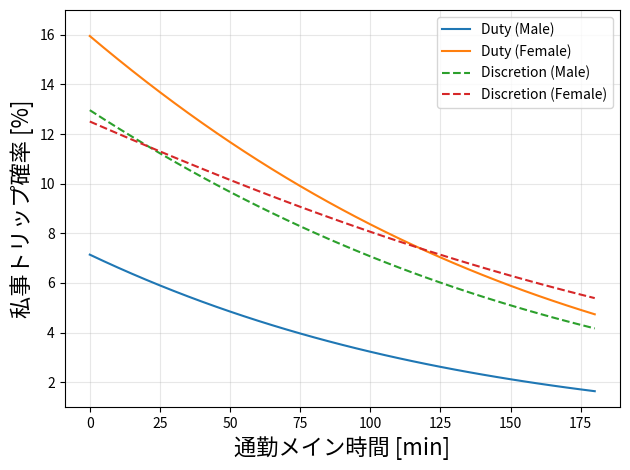

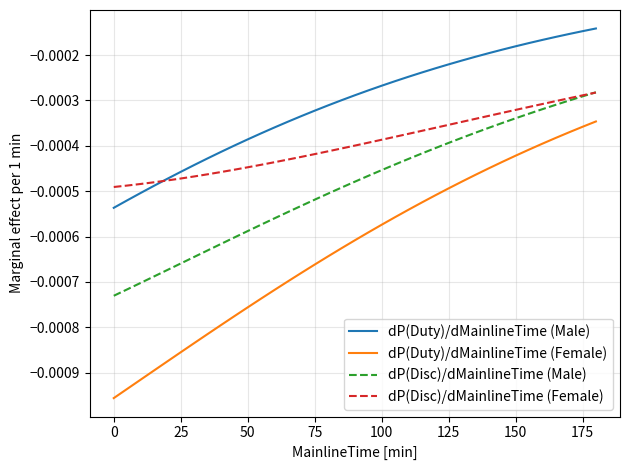

In [14]:
# =========================================================
# 1) 推定結果（指定どおり get_beta_values）
# =========================================================
beta_m = male_results.get_beta_values()
beta_f = female_results.get_beta_values()

# =========================================================
# 2) 固定値（男女共通：master_df 全体平均 + HHM固定）
#    - MainlineTime だけをグリッドで動かす
#    - 端末手段時間は各手段ごとの平均値で固定
# =========================================================
AFwork_time = master_df["AfterTime_work[m]"].mean() / 60.0          # hours
HHM         = 2                                                     # fixed
neki        = master_df["near_1000index2"].mean() / 1_000_000       # scaled

# mode times (minutes) fixed at their means
WA_TT0 = master_df["walk_time[m]"].mean()
BI_TT0 = master_df["bicycle_time[m]"].mean()
BU_TT0 = master_df["bus_time[m]"].mean()
CA_TT0 = master_df["car_time[m]"].mean()

fixed = dict(
    AF_WORKTIME_SCALED=AFwork_time,
    NEKI_SCALED=neki,
    HHM_all=HHM,
    WA_TT=WA_TT0, BI_TT=BI_TT0, BU_TT=BU_TT0, CA_TT=CA_TT0
)

# =========================================================
# 3) 感度分析の横軸：MainlineTime（分）
#    ※あなたのモデルでは MACMTIME_SCALED = MainlineTime/60（hours）
# =========================================================
MACM_grid_min = 0.0
MACM_grid_max = 180.0
step = 5.0
MACM_grid = np.arange(MACM_grid_min, MACM_grid_max + step, step)   # minutes
MACM_h_grid = MACM_grid / 60.0                                      # hours (scaled)

# =========================================================
# 4) 解析式：ネスト確率（Duty / Discretion）と限界効果 dP/dMainlineTime
# =========================================================
def _logsumexp(a, axis=1):
    m = np.max(a, axis=axis, keepdims=True)
    return (m + np.log(np.sum(np.exp(a - m), axis=axis, keepdims=True))).squeeze()

def _softmax3(x0, x1, x2):
    X = np.column_stack([x0, x1, x2])
    m = np.max(X, axis=1, keepdims=True)
    E = np.exp(X - m)
    S = np.sum(E, axis=1, keepdims=True)
    P = E / S
    return P[:, 0], P[:, 1], P[:, 2]

def _cond_probs(mu, V):
    Z = mu * V
    m = np.max(Z, axis=1, keepdims=True)
    E = np.exp(Z - m)
    S = np.sum(E, axis=1, keepdims=True)
    return E / S

def nl_purpose_prob_sens_macm(beta, fixed, MACM_h_array):
    """
    MACM_h_array: MainlineTime scaled in hours (MainlineTime[m]/60)
    Returns:
      P_DU, P_DI, dP_DU_dMACMmin, dP_DI_dMACMmin
      （限界効果は「MainlineTimeを1分増やす」あたりの変化量）
    """
    MACM_h = np.asarray(MACM_h_array)
    N = MACM_h.size

    # parameters
    ASC_DU = beta["ASC_DU"]
    ASC_DI = beta["ASC_DI"]
    ASC_BI = beta.get("ASC_BI", 0.0)
    ASC_BU = beta.get("ASC_BU", 0.0)
    ASC_CA = beta.get("ASC_CA", 0.0)

    b_at     = beta["b_at"]
    b_af     = beta["b_aftime_work"]
    b_mac_du = beta["b_macmtime_du"]
    b_n_du   = beta["b_n_eki_du"]
    b_hhm_du = beta["b_hhm_du"]

    b_mac_di = beta["b_macmtime_di"]
    b_n_di   = beta["b_n_eki_di"]
    b_hhm_di = beta["b_hhm_di"]

    mu_no = 1.0
    mu_du = 1.0 / beta["LAMBDA_DU"]
    mu_di = 1.0 / beta["LAMBDA_DI"]

    # purpose-level utilities (MACM_h varies)
    V_DU_PRI = (
        ASC_DU
        + b_af     * fixed["AF_WORKTIME_SCALED"]
        + b_mac_du * MACM_h
        + b_n_du   * fixed["NEKI_SCALED"]
        + b_hhm_du * fixed["HHM_all"]
    )
    V_DI_PRI = (
        ASC_DI
        + b_af     * fixed["AF_WORKTIME_SCALED"]
        + b_mac_di * MACM_h
        + b_n_di   * fixed["NEKI_SCALED"]
        + b_hhm_di * fixed["HHM_all"]
    )

    # mode utilities (fixed times)
    V_WA = b_at * fixed["WA_TT"]
    V_BI = ASC_BI + b_at * fixed["BI_TT"]
    V_BU = ASC_BU + b_at * fixed["BU_TT"]
    V_CA = ASC_CA + b_at * fixed["CA_TT"]

    # nest alternative utilities (N,4)
    V_du = np.column_stack([
        V_DU_PRI + V_WA,
        V_DU_PRI + V_BI,
        V_DU_PRI + V_BU,
        V_DU_PRI + V_CA,
    ])
    V_di = np.column_stack([
        V_DI_PRI + V_WA,
        V_DI_PRI + V_BI,
        V_DI_PRI + V_BU,
        V_DI_PRI + V_CA,
    ])

    # inclusive values
    IV_no = np.zeros(N)
    IV_du = _logsumexp(mu_du * V_du, axis=1) / mu_du
    IV_di = _logsumexp(mu_di * V_di, axis=1) / mu_di

    # nest probabilities
    P_no, P_DU, P_DI = _softmax3(IV_no, IV_du, IV_di)

    # ---------- analytic marginal effect wrt MainlineTime (minutes)
    # dV_PRI/dMACM_h = b_mac_*
    # MACM_h = MACM_min / 60 => dMACM_h/dMACM_min = 1/60
    # thus dV/dMACM_min = b_mac_*/60  (same for all 4 alts within nest)
    dV_du_per_min = (b_mac_du / 60.0) * np.ones((N, 4))
    dV_di_per_min = (b_mac_di / 60.0) * np.ones((N, 4))

    # within-nest conditional probs
    Pj_du = _cond_probs(mu_du, V_du)
    Pj_di = _cond_probs(mu_di, V_di)

    # dIV/dMACM_min = Σ P(j|nest) * dV_j/dMACM_min
    # here dV_j is constant within a nest, so this collapses to b_mac_*/60,
    # but we keep the generic formula for clarity.
    dIV_no = np.zeros(N)
    dIV_du = np.sum(Pj_du * dV_du_per_min, axis=1)
    dIV_di = np.sum(Pj_di * dV_di_per_min, axis=1)

    avg = P_no * dIV_no + P_DU * dIV_du + P_DI * dIV_di
    dP_DU = P_DU * (dIV_du - avg)
    dP_DI = P_DI * (dIV_di - avg)

    return P_DU, P_DI, dP_DU, dP_DI

# =========================================================
# 5) 計算（男女）
# =========================================================
PDU_m, PDI_m, dPDU_m, dPDI_m = nl_purpose_prob_sens_macm(beta_m, fixed, MACM_h_grid)
PDU_f, PDI_f, dPDU_f, dPDI_f = nl_purpose_prob_sens_macm(beta_f, fixed, MACM_h_grid)

# =========================================================
# 6) 描画：確率
# =========================================================
plt.figure()
plt.plot(MACM_grid, PDU_m * 100, label="Duty (Male)")
plt.plot(MACM_grid, PDU_f * 100, label="Duty (Female)")
plt.plot(MACM_grid, PDI_m * 100, label="Discretion (Male)", linestyle="--")
plt.plot(MACM_grid, PDI_f * 100, label="Discretion (Female)", linestyle="--")
plt.ylim(1, 17)
plt.xlabel("通勤メイン時間 [min]", fontsize=16)
plt.ylabel("私事トリップ確率 [%]", fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# =========================================================
# 7) 描画：限界効果（dP/dMainlineTime）
# =========================================================
plt.figure()
plt.plot(MACM_grid, dPDU_m, label="dP(Duty)/dMainlineTime (Male)")
plt.plot(MACM_grid, dPDU_f, label="dP(Duty)/dMainlineTime (Female)")
plt.plot(MACM_grid, dPDI_m, label="dP(Disc)/dMainlineTime (Male)", linestyle="--")
plt.plot(MACM_grid, dPDI_f, label="dP(Disc)/dMainlineTime (Female)", linestyle="--")
plt.xlabel("MainlineTime [min]")
plt.ylabel("Marginal effect per 1 min")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# 1) 推定結果（指定どおり get_beta_values）
# =========================================================
beta_m = male_results.get_beta_values()
beta_f = female_results.get_beta_values()

# =========================================================
# 2) 固定値（男女共通：master_df 全体平均 + HHM固定）
#    - AfterTime_work だけを動かす
#    - 端末手段時間は各手段の平均値で固定
# =========================================================
MACM_h = master_df["MainlineTime[m]"].mean() / 60.0           # hours（固定）
neki   = master_df["near_1000index2"].mean() / 1_000_000      # scaled（固定）
HHM    = 2                                                    # 固定

WA_TT0 = master_df["walk_time[m]"].mean()
BI_TT0 = master_df["bicycle_time[m]"].mean()
BU_TT0 = master_df["bus_time[m]"].mean()
CA_TT0 = master_df["car_time[m]"].mean()

fixed = dict(
    MACMTIME_SCALED=MACM_h,
    NEKI_SCALED=neki,
    HHM_all=HHM,
    WA_TT=WA_TT0, BI_TT=BI_TT0, BU_TT=BU_TT0, CA_TT=CA_TT0
)

# =========================================================
# 3) 横軸：AfterTime_work（分）
# =========================================================
AF_min, AF_max, step = 0.0, 600.0, 10.0  # 必要に応じて調整
AF_grid = np.arange(AF_min, AF_max + step, step)  # minutes
AF_h_grid = AF_grid / 60.0                         # hours (scaled)

# =========================================================
# 4) 解析式：P(DU), P(DI) とその限界効果を計算
# =========================================================
def _logsumexp(a, axis=1):
    m = np.max(a, axis=axis, keepdims=True)
    return (m + np.log(np.sum(np.exp(a - m), axis=axis, keepdims=True))).squeeze()

def _softmax3(x0, x1, x2):
    X = np.column_stack([x0, x1, x2])
    m = np.max(X, axis=1, keepdims=True)
    E = np.exp(X - m)
    S = np.sum(E, axis=1, keepdims=True)
    P = E / S
    return P[:, 0], P[:, 1], P[:, 2]  # P_no, P_DU, P_DI

def _cond_probs(mu, V):
    Z = mu * V
    m = np.max(Z, axis=1, keepdims=True)
    E = np.exp(Z - m)
    S = np.sum(E, axis=1, keepdims=True)
    return E / S

def nl_purpose_prob_sens_aftertime(beta, fixed, AF_h_array):
    """
    AF_h_array: AfterTime_work scaled in hours (AfterTime_work[m]/60)
    Returns:
      P_DU, P_DI, dP_DU_dAFmin, dP_DI_dAFmin
      （限界効果は「AfterTime_work を1分増やす」あたり）
    """
    AF_h = np.asarray(AF_h_array)
    N = AF_h.size

    # parameters
    ASC_DU = beta["ASC_DU"]
    ASC_DI = beta["ASC_DI"]
    ASC_BI = beta.get("ASC_BI", 0.0)
    ASC_BU = beta.get("ASC_BU", 0.0)
    ASC_CA = beta.get("ASC_CA", 0.0)

    b_at   = beta["b_at"]
    b_af   = beta["b_aftime_work"]        # 共通
    b_mac_du = beta["b_macmtime_du"]
    b_n_du   = beta["b_n_eki_du"]
    b_hhm_du = beta["b_hhm_du"]

    b_mac_di = beta["b_macmtime_di"]
    b_n_di   = beta["b_n_eki_di"]
    b_hhm_di = beta["b_hhm_di"]

    mu_no = 1.0
    mu_du = 1.0 / beta["LAMBDA_DU"]
    mu_di = 1.0 / beta["LAMBDA_DI"]

    # purpose-level utilities (AF varies)
    V_DU_PRI = (
        ASC_DU
        + b_af     * AF_h
        + b_mac_du * fixed["MACMTIME_SCALED"]
        + b_n_du   * fixed["NEKI_SCALED"]
        + b_hhm_du * fixed["HHM_all"]
    )
    V_DI_PRI = (
        ASC_DI
        + b_af     * AF_h
        + b_mac_di * fixed["MACMTIME_SCALED"]
        + b_n_di   * fixed["NEKI_SCALED"]
        + b_hhm_di * fixed["HHM_all"]
    )

    # mode utilities (fixed mode times)
    V_WA = b_at * fixed["WA_TT"]
    V_BI = ASC_BI + b_at * fixed["BI_TT"]
    V_BU = ASC_BU + b_at * fixed["BU_TT"]
    V_CA = ASC_CA + b_at * fixed["CA_TT"]

    # utilities in each nest (N,4)
    V_du = np.column_stack([V_DU_PRI + V_WA, V_DU_PRI + V_BI, V_DU_PRI + V_BU, V_DU_PRI + V_CA])
    V_di = np.column_stack([V_DI_PRI + V_WA, V_DI_PRI + V_BI, V_DI_PRI + V_BU, V_DI_PRI + V_CA])

    # inclusive values
    IV_no = np.zeros(N)
    IV_du = _logsumexp(mu_du * V_du, axis=1) / mu_du
    IV_di = _logsumexp(mu_di * V_di, axis=1) / mu_di

    # nest probs
    P_no, P_DU, P_DI = _softmax3(IV_no, IV_du, IV_di)

    # ----- marginal effects wrt AfterTime_work (minutes)
    # AF_h = AF_min / 60 => d(AF_h)/d(AF_min) = 1/60
    d_per_min = b_af / 60.0  # same across all alts in DU and DI nests

    Pj_du = _cond_probs(mu_du, V_du)
    Pj_di = _cond_probs(mu_di, V_di)

    dIV_no = np.zeros(N)
    dIV_du = np.sum(Pj_du * (d_per_min * np.ones((N, 4))), axis=1)
    dIV_di = np.sum(Pj_di * (d_per_min * np.ones((N, 4))), axis=1)

    avg = P_no * dIV_no + P_DU * dIV_du + P_DI * dIV_di
    dP_DU = P_DU * (dIV_du - avg)
    dP_DI = P_DI * (dIV_di - avg)

    return P_DU, P_DI, dP_DU, dP_DI

# =========================================================
# 5) 男女それぞれ：私事トリップ確率 P_trip = P_DU + P_DI
# =========================================================
PDU_m, PDI_m, dPDU_m, dPDI_m = nl_purpose_prob_sens_aftertime(beta_m, fixed, AF_h_grid)
PDU_f, PDI_f, dPDU_f, dPDI_f = nl_purpose_prob_sens_aftertime(beta_f, fixed, AF_h_grid)

Ptrip_m = PDU_m + PDI_m
Ptrip_f = PDU_f + PDI_f

# 解析的感度（限界効果）も「和」でOK
dPtrip_m = dPDU_m + dPDI_m
dPtrip_f = dPDU_f + dPDI_f

# =========================================================
# 6) 描画：私事トリップ確率のみ（男女比較）
# =========================================================
plt.figure()
plt.plot(AF_grid, Ptrip_m * 100, label="Private trip (Male)")
plt.plot(AF_grid, Ptrip_f * 100, label="Private trip (Female)")
plt.xlabel("AfterTime_work [min]")
plt.ylabel("Private trip probability [%]")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# =========================================================
# 7) （任意）描画：感度の差を直接見る（dP_trip/dAfterTime）
#     不要ならこのブロックをコメントアウトしてください
# =========================================================
plt.figure()
plt.plot(AF_grid, dPtrip_m, label="dP_trip/dAfterTime (Male)")
plt.plot(AF_grid, dPtrip_f, label="dP_trip/dAfterTime (Female)")
plt.xlabel("AfterTime_work [min]")
plt.ylabel("Marginal effect per 1 min")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
